## Using CNN for radiomics study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pydicom
from pydicom.data import get_testdata_file, get_testdata_files
from pydicom.filereader import read_dicomdir
import pydicom_seg
from skimage.draw import polygon

import os
import sys
import glob

#import tensorflow as tf
#import keras

Plan of attack:

1. Load DICOM images with segmentation as mask
2. Remove everything outside the mask
3. Set up neural network and pass it through

### Loading DICOM images

Define two functions:
(Source: http://aapmchallenges.cloudapp.net/forums/3/2/)

In [24]:
def read_structure(structure):
    contours = []
    
    for i in range(len(structure.ROIContourSequence)):
        
        # Only include GTVs
        if ("gtv" not in structure.StructureSetROISequence[i].ROIDescription.lower()):
            continue
        
        contour = {}
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
        
    return contours

In [32]:
def get_mask(contours, slices):
    z = [s.ImagePositionPatient[2] for s in slices]
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    
    for con in contours:
        # Original code, for distinguishing between different structures
        # num = int(con['number'])
        
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3))
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(nodes[0, 2])
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            # Original code, for distinguishing between different structures
            # label[rr, cc, z_index] = num
            label[rr, cc, z_index] = 1

        colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors

Try a patient with multiple GTVs:

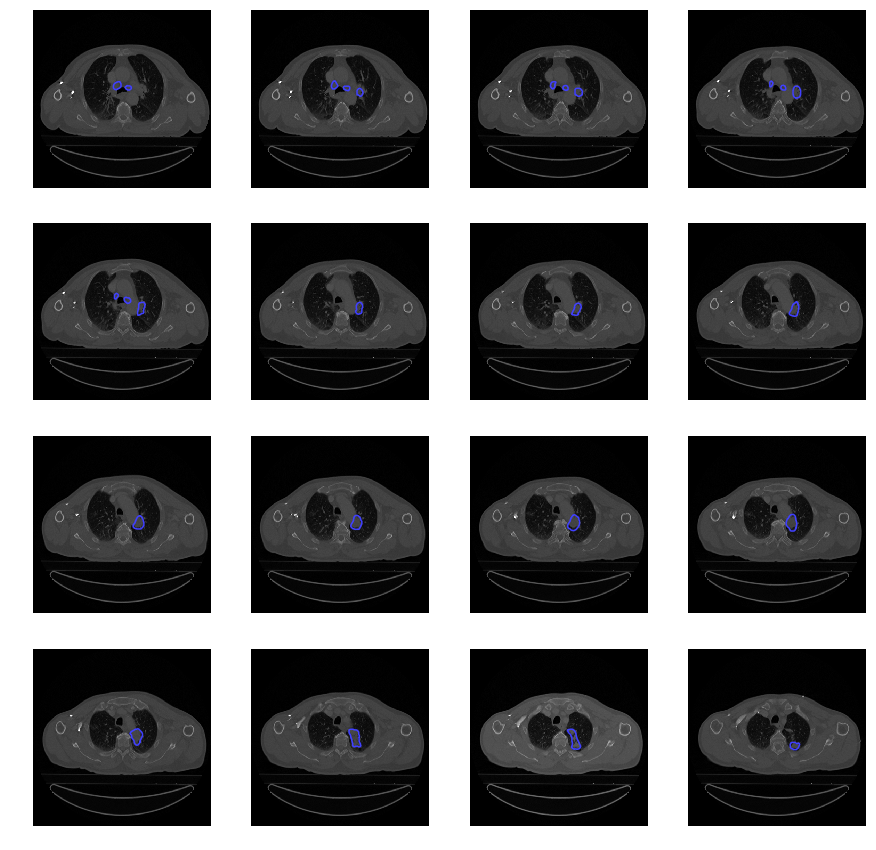

In [33]:
train_data_path = "/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/LUNG1-003"
ct_contours_folders = [os.path.join(train_data_path, name) 
                       for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]

# There are two folders
# One containing the CT images
# The other containing the contours
# Always load the contour (RTSTRUCT) file first
if ('CTLUNG' not in ct_contours_folders[0]):
    ct_contours_folders[1], ct_contours_folders[0] = ct_contours_folders[0], ct_contours_folders[1]

# Then loop through each of the two folders
for folder in ct_contours_folders:
    for subdir, dirs, files in os.walk(folder):

        dcms = glob.glob(os.path.join(subdir, "*.dcm"))

        # Do not include segmentation file
        if len(dcms) == 1:
            if ('Segmentation' not in dcms[0]):
                structure = pydicom.read_file(os.path.join(subdir, files[0]))
                contours = read_structure(structure)
        elif len(dcms) > 1:
            slices = [pydicom.read_file(dcm) for dcm in dcms]
            slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            image = np.stack([s.pixel_array for s in slices], axis=-1)

            label, colors = get_mask(contours, slices)

# Plot to check slices
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image[..., i+50], cmap="gray")
    plt.contour(label[..., i+50], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
    plt.axis('off')

Define a `masked_img` variable where everything outside the contour is removed:

In [37]:
masked_img = np.multiply(image, label)

This works. We now loop over all the patients.